# Chapter 8: Dimensionality Reduction

Too many dimensions is a problem, especially as:
1. There are too many features, leading to slower training.
2. The models might not generalize well.
3. The behavior of objects in a higher-dimensional space is not intuitive, so some of our expectations break down.

How can the space between two points in a 1 million dimension hypercube be roughly 408.25? I can't derive it theoratically, so let's derive it empirically.

Let's generate a billion sets of points in a 1M space, and then calculate the space between them

In [206]:
import numpy as np
from sklearn.linear_model import SGDClassifier


In [204]:
import numpy as np

# Run later
d={}
runs = 1000000

for dimensions in (1, 2, 3, 4, 10, 100, 1000, 1000000):
    sum_distance = 0.0

    for i in range(runs):
        a=np.random.rand(dimensions)
        b=np.random.rand(dimensions)
        sum_distance += np.linalg.norm(a-b)
    
    sum_distance /= (1.0*runs)
    print ("Mean distance in dimension %d is %f" % (dimensions, sum_distance))
    d[str(dimensions)] = sum_distance


Mean distance in dimension 1 is 0.333132
Mean distance in dimension 2 is 0.522009
Mean distance in dimension 3 is 0.662000
Mean distance in dimension 4 is 0.777768
Mean distance in dimension 10 is 1.267634
Mean distance in dimension 100 is 4.075214
Mean distance in dimension 1000 is 12.907721
Mean distance in dimension 1000000 is 408.248090


In [207]:
d

{'1': 0.33313242146109745,
 '2': 0.5220087489532168,
 '3': 0.6619995758767101,
 '4': 0.7777682018511076,
 '10': 1.267633508688113,
 '100': 4.075213642842331,
 '1000': 12.907721090890442,
 '1000000': 408.2480901563407}

# Principal Components Analysis

Reducing dimensions by getting the principal components' eigenvectors from an SVD (Singular Value Decomposition) and then transforming to a space of the first few eigenvectors that explain most of the variance.

This helps in reducing the space down (fewer attributes, smaller data) and in computational cost of training and predicting classifiers.

The only hitch is that the SVD is time consuming, but you only need to do it once.


In [208]:
# All imports


import time as time
import numpy as np

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib as mpl

from sklearn.cluster import AgglomerativeClustering

from sklearn.datasets import fetch_openml
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV




In [209]:
# Download the MNIST data if it isn't available. Cached in ~/scikit_learn_data
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [210]:
# Assign attributes and labels using standard terminology
X, y = mnist["data"], mnist["target"]

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print (X.shape)
print (y.shape)

(70000, 784)
(70000,)


In [211]:
pca = PCA(n_components=2)
X2d = pca.fit_transform(X)

In [212]:
X2d[:10,:]

array([[ 122.25084639, -316.22216849],
       [1010.49344479, -289.98197009],
       [ -58.99707858,  393.69299281],
       [-796.96637981, -607.4199964 ],
       [-391.31545862,  729.78817111],
       [ 185.9692645 ,  223.86427753],
       [-730.48683912, -161.99810841],
       [ 503.48490812, -308.74390008],
       [-874.55226058,  -84.30694005],
       [-304.01660076,  463.58988569]])

In [213]:
pca.explained_variance_ratio_

array([0.09746116, 0.07155445])

As you can see, the 2 dimensions only explain 16.8% of the variance. This means we have lost too much information. Instead, let's run full PCA and see how many dimensions we need.

In [214]:
full_pca = PCA()
full_pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [215]:
full_pca.explained_variance_ratio_

array([9.70466436e-02, 7.09592406e-02, 6.16908876e-02, 5.38941949e-02,
       4.86879702e-02, 4.31223132e-02, 3.27192995e-02, 2.88389545e-02,
       2.76202940e-02, 2.35700055e-02, 2.10918962e-02, 2.02299108e-02,
       1.71581820e-02, 1.69211143e-02, 1.57864128e-02, 1.48295261e-02,
       1.32456095e-02, 1.27689737e-02, 1.18726294e-02, 1.15268370e-02,
       1.06616621e-02, 1.00671337e-02, 9.53573327e-03, 9.12543746e-03,
       8.83404692e-03, 8.39319141e-03, 8.12578809e-03, 7.86366084e-03,
       7.44733102e-03, 6.90859128e-03, 6.58093773e-03, 6.48147870e-03,
       6.02615030e-03, 5.86582188e-03, 5.70021474e-03, 5.43627771e-03,
       5.05786416e-03, 4.87858604e-03, 4.81429342e-03, 4.72266326e-03,
       4.56746921e-03, 4.44836012e-03, 4.18501329e-03, 3.98215339e-03,
       3.84974607e-03, 3.75103387e-03, 3.62008852e-03, 3.51591277e-03,
       3.40058205e-03, 3.21874467e-03, 3.19017051e-03, 3.12804939e-03,
       2.95982668e-03, 2.88954600e-03, 2.84130398e-03, 2.71435811e-03,
      

In [216]:
cumsum = np.cumsum(full_pca.explained_variance_ratio_)

In [217]:
d = np.argmax(cumsum >= 0.95) + 1
print(d)
W_d = full_pca.components_.T[:, 0:154]


154


So now, we can get the first 154 dimensions into an array called $W_d$ and then project to hyperplane (by centering the input and multiplying by $W_d$.
```
centers = X.mean(axis=0)
W_d = pca.components_.T[:, 0:154]

def project_to_hyperplane(X):
    X_centered = X - centers
    return X_centered.dot(W_d)
    
```

And restore to original space by multiplying by $W_d^T$ and undoing the centering.
```
centers = X.mean(axis=0)
W_d = pca.components_.T[:, 0:154]

def project_to_original_space(X_d):
    return X_centered.dot(W_d.T)
    return X + centers
    
```

 I was not able to find a way to get the centering for the PCA.
 TODO: later.

In [218]:
# W_d = pca.components_.T[:, 0:154]

X_orig = X[0]
X_d = X_orig.dot(W_d)
X_back = X_d.dot(W_d.T)

# How much information did we lose here

print(np.linalg.norm(X_back - X_orig))

502.4619569191871


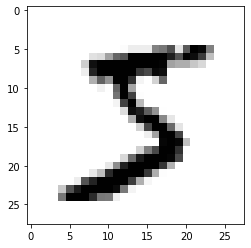

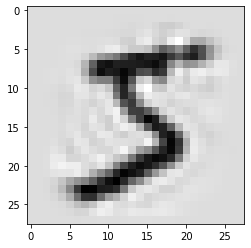

In [219]:
showImage(X_orig)
showImage(X_back)

This doesn't look right. I suspect the centering is missing. Let's do this with the pca instead.

In [220]:
print("Shape of PCA.means is ", pca.mean_.shape)

centers = full_pca.mean_
W_d = full_pca.components_.T[:, 0:50]

def project_to_hyperplane(X):
    X_centered = X - centers
    return X_centered.dot(W_d)

def project_to_original_space(X_d):
    return X_d.dot(W_d.T)
    return X + centers

X_d = project_to_hyperplane(X_orig)
X_back = project_to_original_space(X_d)

# How much information did we lose here
print(X_back.shape)
print(np.linalg.norm(X_back - X_orig))


Shape of PCA.means is  (784,)
(784,)
1755.4455291237537


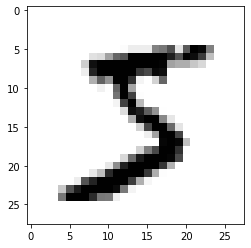

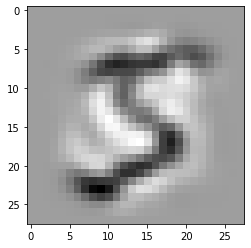

In [221]:
showImage(X_orig)
showImage(X_back)

In order to preserve x% of the variance, you can specify the fraction directly as the n_components argument to PCA. This has the advantage of giving you a fit_transform() and an inverse_transform method, rather than doing matrix manipulation to project onto the hyperplane and back to the original space.

[Scaling is very important before running PCA](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py). We didn't do that because the MNIST pixel values are already scaled to be in the same range, but this should be done before running PCA.

In [222]:
from sklearn.linear_model import SGDClassifier

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [223]:
def showImage(digit):
    # The description tells you that these are 28x28 pixel boxes
    digit_image = digit.reshape(28,28)
    plt.imshow(digit_image, cmap='binary')
    plt.axis("on")
    plt.show()

501.71189921420125


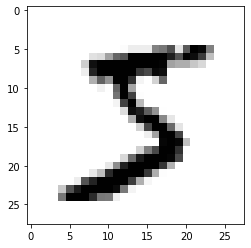

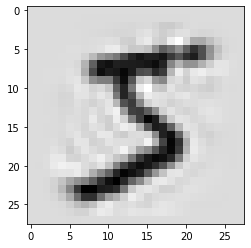

In [224]:
X_orig = X[0].copy()
X_reduced = pca.transform([X_orig])
X_recovered = pca.inverse_transform([X_reduced])

# How much information did we lose here
print(np.linalg.norm(X_orig - X_recovered))

# And let's plot them both
showImage(X_orig)
showImage(X_recovered)

# Randomized PCA

An approximate SVD implementation when svd_solver="randomized".

But rnd_pca doesn't like fractional values for n_components, as it needs to know the number of dimensions right away.

In [225]:
rnd_pca = PCA(n_components=154,  svd_solver="randomized")

In [226]:
%time rnd_pca.fit(X_train)

CPU times: user 4min 48s, sys: 1.51 s, total: 4min 50s
Wall time: 4min 50s


PCA(copy=True, iterated_power='auto', n_components=154, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False)

Compare this with a full PCA


In [227]:
%time X_reduced = pca.fit_transform(X_train)

CPU times: user 4min 5s, sys: 1.22 s, total: 4min 6s
Wall time: 4min 3s


498.9340620402631


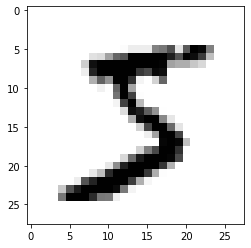

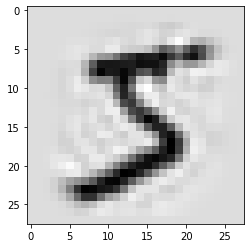

In [228]:
digit_reduced = rnd_pca.transform([one_digit])
digit_recovered = rnd_pca.inverse_transform([digit_reduced])

# How much information did we lose here
print(np.linalg.norm(one_digit - digit_recovered))

# And let's plot them both
showImage(one_digit)
showImage(digit_recovered)

# Incremental PCA

Instead of training on the full dataset, we can train on subsets of the data in two ways.

One, we can use IncrementalPCA.

The second is more interesting, where we create a disk-backed matrix
```
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m,n))
batch_size = m
inc_pca = IncrementalPca(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)
```

This works well for large datasets $(m >> n)$ that won't fit in memory but you want IncrementalPCA to go through the whole matrix.

In [229]:
from sklearn.decomposition import IncrementalPCA

one_digit = X[0].copy()

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)


485.306290320977


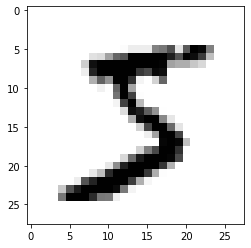

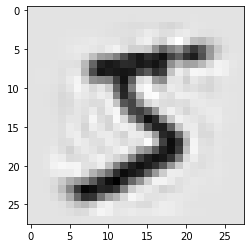

In [230]:
digit_reduced = inc_pca.transform([one_digit])
digit_recovered = inc_pca.inverse_transform([digit_reduced])

# How much information did we lose here
print(np.linalg.norm(one_digit - digit_recovered))

# And let's plot them both
showImage(one_digit)
showImage(digit_recovered)

In [231]:
digit_reduced.shape

(1, 154)

# Swiss Roll database and Kernel PCA

Till now we used the digits database, and it is not a manifold. So let's use the [Swiss roll database](https://scikit-learn.org/stable/auto_examples/cluster/plot_ward_structured_vs_unstructured.html#sphx-glr-auto-examples-cluster-plot-ward-structured-vs-unstructured-py) which is a 2d manifold in a 3d space. And let's try different dimensionality reduction methods on it.

In [232]:
print(__doc__)

import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll

# Generate data (swiss roll dataset)
n_samples = 1500
noise = 0.05

# t is the location in the manifold, something that we usually would not have access
# to, but in this toy data generator, we have the true value.
X, t = make_swiss_roll(n_samples, noise=noise)

# Make it thinner
X[:, 1] *= .5


Automatically created module for IPython interactive environment


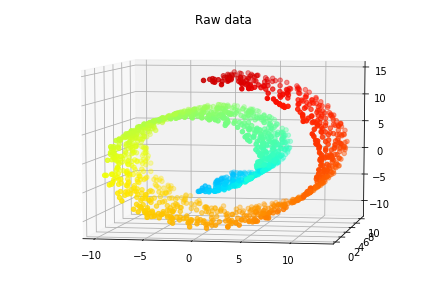

In [233]:
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
max_color=np.max(t + 1)
scaled_color = t / max_color

ax.scatter(X[:, 0], X[:, 1], X[:, 2], 
            color=plt.cm.jet(scaled_color), s=20)
plt.title('Raw data');


You can use the kernel trick with PCA as well. So you apply different modifications a
(called kernels) that transform the original space to another space, and then PCA
acts upon that space to reduce the dimensions. 

Where this can be helpful is when the original space is messy, and a Sigmoid or Radial Basis Function (RBF) kernel can modify this space, while keeping the data intact, and then PCA can reduce the information to just the important components.

In [234]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

/usr/lib/python3/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


In [235]:
X_reduced.shape

(1500, 2)

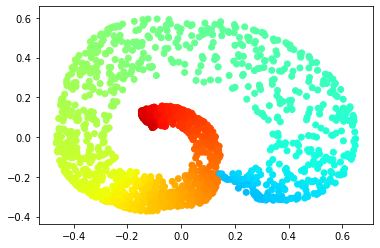

In [236]:
plt.scatter(X_reduced[:,0], X_reduced[:, 1], color=plt.cm.jet(scaled_color))
plt.axis("on")
plt.show()

This part is complicated, you can create a pipeline, and then feed it to GridSearch to evaluate across all elements in the pipeline. Fancy

In [237]:
clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('lin_reg', LinearRegression(copy_X=True))
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid', 'linear'],
    'lin_reg__normalize': [True, False]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, t)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('lin_reg',
                                 

In [238]:
grid_search.best_params_

{'kpca__gamma': 0.05, 'kpca__kernel': 'rbf', 'lin_reg__normalize': False}

In [239]:
grid_search.predict([X[0]])

array([10.43647188])

In [240]:
t[0]

8.53427115091722

Pretty close, it was able to do a good job.

When we use KernelPCA, the mapping from the transform really goes from the original space, to a modified feature space $\phi(x) \in \phi(X)$. Then, PCA reduces the dimensions of this space to a lower dimension space called $Y$. So if we restore from
$y \in Y$, using an inverse of $\phi$, then you are back in the modified feature-space $\phi(X)$ rather than in $X$. So instead of using this larger (potentially infinite) space, we can find a point in the original space $X$ that is close-enough to the location in $\phi(X)$. This is done by passing fit_inverse_transform=True to KernelPCA like this.

In [241]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433,
                   fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)

In [242]:
X_preimage = rbf_pca.inverse_transform(X_reduced)

# Exercises

1. Main motivation for reducing dimensionality:
    - Preserving information while reducing features.
    - Graphing or examining data visually.
    - Training models that choke on a large number of features.
    - Getting more robust models that can find similarities between points in a denser space.


2. Curse of dimensionality:
    - When the data is so sparsely represented that any relationship between them is lost.
    
    
3. Is it possible to reverse the reduction of dimensionality?
    - Yes, it is possible if the information loss is not too large. For example, with MNIST, if you end up with two dimensions, you cannot regain back the original information.
    - In extreme cases, you could let go of superfluous attributes and get information back fully.
    - From a vector in the reduced space $X_d$, and the vector $W_d$ that transforms from the full space to the reduced space: $X_d = X . W_d$, you can get the original space by undoing this operation: $X = X_d . W_d^T$. This is possible because of two key reasons
       - $W_d$ has unit vectors, so you don't need to divide by their norm.
       - $W_d$ has orthornomal vectors, so they are at right angles to each other: they are basis vectors of the projection space because they are obtained through the Singular Value Decomposition (SVD).
    
    
4. Can PCA be used to reduce dimensionality of a highly nonlinear dataset:
    - Probably not, unless the Kernel trick is used. After all PCA is the result of SVD, and SVD is an affine transformation from the original space to another (possibly smaller space). Affine transformations are rotations and stretches. Highly nonlinear operations cannot be expressed as matrix transformations.


5. How many dimensions will a 1000-dimension dataset will have at 95% variance ratio
    - Impossible to tell without more information. It could be 0 dimension (if the dataset is the same value repeated forever). It could be all 1000 dimensions if each dimension is independent.


6. When do you use vanilla PCA, Incremental, Randomized, or Kernel
    - Vanilla: Dataset is small, many attributes carry little information $ d << n $, information is linear
    - Incremental: Dataset ($m$) is large, and won't fit in memory. Approximations are ok.
    - Randomized: $d << n$ and approximations are fine.
    - Kernel: Information in the dataset is not linear.


7. How we evaluate dimensionality reduction?
    - Find how much variance is explained on the training set. This should be large.
    - If reducing dimensions for viewing, the information should be preserved (clusters are preserved, relations are somewhat retained)
    - If doing this for training a model that chokes on a large number of attributes, then the model training is sped up sufficiently.


8. Is there any sense to reducing dimensionality, and then doing it again?
    - Probably not in most cases. Better to do an SVD once.
    - But in case the original dimensions are large with most attributes superflous($n$ huge, $d << n$), then an approximate SVD followed by a full SVD on the projected space might be useful.
    
9. Train Random Forest on MNIST... 

In [243]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [244]:
# Assign attributes and labels using standard terminology
X, y = mnist["data"], mnist["target"]

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print (X.shape)
print (y.shape)

(70000, 784)
(70000,)


In [245]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier()

In [246]:
%time forest.fit(X_train, y_train)

CPU times: user 1min 33s, sys: 104 ms, total: 1min 33s
Wall time: 1min 33s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [247]:
print (accuracy_score(forest.predict(X_test), y_test))

0.9682


Now reduce the dimensions to 95%, and then train, and time the whole thing, including the PCA.

In [248]:
pca = PCA(n_components=.95)

In [249]:
%time pca.fit(X_train)

CPU times: user 4min 4s, sys: 1.31 s, total: 4min 5s
Wall time: 4min 3s


PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [250]:
# Transform all the attributes.
%time Xs_train = pca.transform(X_train)

CPU times: user 18.2 s, sys: 116 ms, total: 18.3 s
Wall time: 18.3 s


In [251]:
%time Xs_test = pca.transform(X_test)

CPU times: user 3.19 s, sys: 24 ms, total: 3.21 s
Wall time: 3.21 s


In [252]:
forest_small = RandomForestClassifier()


In [253]:
%time forest_small.fit(Xs_train, y_train)

CPU times: user 3min 20s, sys: 176 ms, total: 3min 20s
Wall time: 3min 20s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [254]:
print (accuracy_score(forest_small.predict(Xs_test), y_test))

0.9468


10. t-SNE to visualize the MNIST dataset

In [255]:
from sklearn.manifold import TSNE

%time tsne = TSNE(n_components=2)

CPU times: user 28 µs, sys: 0 ns, total: 28 µs
Wall time: 34.8 µs


In [ ]:
%time X_tsne = tsne.fit_transform(X)

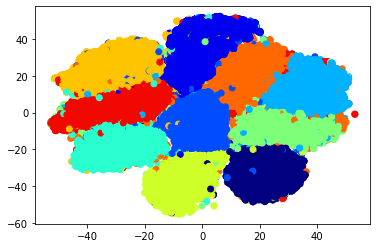

In [259]:
scaled_color = y.astype(np.float32) / 10.0
plt.scatter(X_tsne[:,0], X_tsne[:, 1], color=plt.cm.jet(scaled_color))
plt.axis("on")
plt.show()